In [1]:
import pandas as pd
import numpy as np 
import csv
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = '/home/manikya_varshney/Documents/Python/Yale/Graph Data/april01.csv'
data = pd.read_csv(path, low_memory=False)

In [3]:
data.shape

(16190, 14)

In [4]:
data['lang'].value_counts()

en    16190
Name: lang, dtype: int64

# Data Cleaning

##### is_quote --> False 

In [5]:
interim = data[np.where((data['is_quote']==False),True,False)].reset_index(drop=True)

In [6]:
interim.shape

(14699, 14)

In [7]:
non_rep = interim[['user_id','text']]

##### is_quote --> True 

In [8]:
interim = data[np.where((data['is_quote']== True),True,False)].reset_index(drop=True)

In [9]:
interim.shape

(1491, 14)

In [10]:
interim = interim[['user_id','text']]

In [11]:
interim.columns = non_rep.columns

In [12]:
interim.shape

(1491, 2)

In [13]:
non_rep = non_rep.append(interim,ignore_index=True)

In [14]:
non_rep.shape

(16190, 2)

In [15]:
interim = data[np.where((data['is_quote']== True),True,False)].reset_index(drop=True)

In [16]:
interim.shape

(1491, 14)

In [17]:
interim[['quoted_text']]

,quoted_text
0,Saw this research paper here on twitter and I ...
1,The Guardian view on Jair Bolsonaro: a danger ...
2,An engineer deliberately ran a train off the t...
3,"Soooo saaaaaaaad to finally announce this, but..."
4,"I’m gonna give away $5,000 to 3 random people ..."
...,...
1486,Part of a 1938 public health map: https://t.co...
1487,"A New York radio reporter, a party on LBI, and..."
1488,This White House briefing room slide lists as ...
1489,While the resourcefulness and hustle shown by ...


In [18]:
interim = interim[['quoted_user_id','quoted_text']]

In [19]:
interim

,quoted_user_id,quoted_text
0,3.379014e+09,Saw this research paper here on twitter and I ...
1,5.128255e+07,The Guardian view on Jair Bolsonaro: a danger ...
2,1.899340e+07,An engineer deliberately ran a train off the t...
3,1.623403e+07,"Soooo saaaaaaaad to finally announce this, but..."
4,1.823623e+07,"I’m gonna give away $5,000 to 3 random people ..."
...,...,...
1486,9.186279e+08,Part of a 1938 public health map: https://t.co...
1487,1.965532e+07,"A New York radio reporter, a party on LBI, and..."
1488,2.323220e+07,This White House briefing room slide lists as ...
1489,1.240031e+18,While the resourcefulness and hustle shown by ...


In [20]:
interim = interim.rename(columns={'quoted_user_id':'user_id', 'quoted_text':'text'})

In [21]:
non_rep = non_rep.append(interim,ignore_index=True)

In [22]:
non_rep.shape

(17681, 2)

In [23]:
non_rep

,user_id,text
0,2.843399e+07,As Chicago households fill out 2020 census dur...
1,1.010439e+08,Most of the press corps is very busy covering ...
2,1.647527e+07,@realDonaldTrump Mar 10–he was very specific: ...
3,1.647527e+07,"@realDonaldTrump , You were caustic &amp; sarc..."
4,3.453977e+08,"Florida nears 8,000 coronavirus cases, as stat..."
...,...,...
17676,9.186279e+08,Part of a 1938 public health map: https://t.co...
17677,1.965532e+07,"A New York radio reporter, a party on LBI, and..."
17678,2.323220e+07,This White House briefing room slide lists as ...
17679,1.240031e+18,While the resourcefulness and hustle shown by ...


# Analysis

In [24]:
import pandas as pd
import numpy as np 
import csv
import re
import string
import emoji

import nltk
from nltk import pos_tag, pos_tag_sents
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [25]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english')) - set(['at', 'do', 'your', 'from', 'to', 'out', 'no', 'the'])
#demoji.download_codes()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manikya_varshney/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/manikya_varshney/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/manikya_varshney/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/manikya_varshney/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
non_rep['text_duplicate'] = non_rep['text']

In [27]:
non_rep

,user_id,text,text_duplicate
0,2.843399e+07,As Chicago households fill out 2020 census dur...,As Chicago households fill out 2020 census dur...
1,1.010439e+08,Most of the press corps is very busy covering ...,Most of the press corps is very busy covering ...
2,1.647527e+07,@realDonaldTrump Mar 10–he was very specific: ...,@realDonaldTrump Mar 10–he was very specific: ...
3,1.647527e+07,"@realDonaldTrump , You were caustic &amp; sarc...","@realDonaldTrump , You were caustic &amp; sarc..."
4,3.453977e+08,"Florida nears 8,000 coronavirus cases, as stat...","Florida nears 8,000 coronavirus cases, as stat..."
...,...,...,...
17676,9.186279e+08,Part of a 1938 public health map: https://t.co...,Part of a 1938 public health map: https://t.co...
17677,1.965532e+07,"A New York radio reporter, a party on LBI, and...","A New York radio reporter, a party on LBI, and..."
17678,2.323220e+07,This White House briefing room slide lists as ...,This White House briefing room slide lists as ...
17679,1.240031e+18,While the resourcefulness and hustle shown by ...,While the resourcefulness and hustle shown by ...


In [28]:
#Convert to lower case
non_rep['text'] = non_rep['text'].str.lower()

In [29]:
#Removing emojis
def demoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00010000-\U0010ffff"
                               "]+", flags=re.UNICODE)
    return(emoji_pattern.sub(r'', text))

non_rep[u'text'] = non_rep[u'text'].astype(str)
non_rep[u'text'] = non_rep[u'text'].apply(lambda x:demoji(x))

In [30]:
#Remove URLs
non_rep['text'] = non_rep['text'].str.replace(r"http\S+| www\S+| https\S+| \S+\.com\S+| \S+\.com", "", regex=True)

In [31]:
#Remove user @
non_rep['text'] = non_rep['text'].str.replace(r'\@[\w]+', "", regex=True)

In [32]:
#Remove punctuations
non_rep['text'] = non_rep['text'].str.translate(str.maketrans("", "", string.punctuation))

In [33]:
#More Cleaning
non_rep['text']=non_rep['text'].astype(str).str.replace('/[^a-zA-Z0-9 ]/g', '', regex=True).str.replace('\n',' ', regex=True).str.replace('—',' ', regex=True).str.strip('“').str.strip('”').str.strip('’').str.lstrip(' ').str.rstrip(' ')

In [34]:
#Tokenizing
non_rep.text = non_rep.text.astype(str)
non_rep['tokenized_text'] = non_rep.apply(lambda row: nltk.word_tokenize(row.text), axis=1)

# remove stopwords
non_rep['filtered_text'] = non_rep['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])

In [35]:
#Stemming
ps = PorterStemmer()
non_rep['stemmed_text'] = non_rep['filtered_text'].apply(lambda x: [ps.stem(y) for y in x])

In [36]:
#POSTags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [37]:
#Lemmatizing
lemmatizer = WordNetLemmatizer()
non_rep['lemmatized_text'] = non_rep['filtered_text'].apply(lambda x: [lemmatizer.lemmatize(y, get_wordnet_pos(y)) for y in x])

In [38]:
#Joining the lemmetized tokens to form string
non_rep['final'] = non_rep['lemmatized_text'].apply(lambda x: " ".join([word for word in x]))

In [39]:
#Remove punctuations
non_rep['final'] = non_rep['final'].str.translate(str.maketrans("", "", string.punctuation))
non_rep['final'] = non_rep['final'].str.replace("’", '').str.replace("“", '').str.replace("”", '')
#non_rep['text'] = non_rep['text'].astype(str).str.replace('/[^a-zA-Z0-9 ]/g', '', regex=True).str.replace('\n',' ', regex=True).str.replace('—',' ', regex=True).str.strip('“').str.strip('”').str.strip('’').str.lstrip(' ').str.rstrip(' ')
non_rep['final'] = non_rep['final'].astype(str).str.replace('/[^a-zA-Z0-9 ]/g', '', regex=True).str.replace('\n',' ', regex=True).str.replace('—',' ', regex=True).str.strip('“').str.strip('”').str.strip('’').str.lstrip(' ').str.rstrip(' ')

In [40]:
non_rep.drop_duplicates(['final']).shape

(16925, 8)

In [41]:
non_rep = non_rep.drop_duplicates(['final']).reset_index(drop=True)

In [42]:
non_rep.shape

(16925, 8)

In [43]:
non_rep

,user_id,text,text_duplicate,tokenized_text,filtered_text,stemmed_text,lemmatized_text,final
0,2.843399e+07,as chicago households fill out 2020 census dur...,As Chicago households fill out 2020 census dur...,"[as, chicago, households, fill, out, 2020, cen...","[chicago, households, fill, out, 2020, census,...","[chicago, household, fill, out, 2020, censu, c...","[chicago, household, fill, out, 2020, census, ...",chicago household fill out 2020 census coronav...
1,1.010439e+08,most of the press corps is very busy covering ...,Most of the press corps is very busy covering ...,"[most, of, the, press, corps, is, very, busy, ...","[the, press, corps, busy, covering, the, reall...","[the, press, corp, busi, cover, the, realli, i...","[the, press, corp, busy, cover, the, really, i...",the press corp busy cover the really important...
2,1.647527e+07,mar 10–he was very specific “google has 1700 e...,@realDonaldTrump Mar 10–he was very specific: ...,"[mar, 10–he, was, very, specific, “, google, h...","[mar, 10–he, specific, “, google, 1700, engine...","[mar, 10–he, specif, “, googl, 1700, engin, wo...","[mar, 10–he, specific, “, google, 1700, engine...",mar 10–he specific google 1700 engineer work ...
3,1.647527e+07,you were caustic amp sarcastic about the rollo...,"@realDonaldTrump , You were caustic &amp; sarc...","[you, were, caustic, amp, sarcastic, about, th...","[caustic, amp, sarcastic, the, rollout, ’, com...","[caustic, amp, sarcast, the, rollout, ’, come,...","[caustic, amp, sarcastic, the, rollout, ’, com...",caustic amp sarcastic the rollout come even f...
4,3.453977e+08,florida nears 8000 coronavirus cases as state ...,"Florida nears 8,000 coronavirus cases, as stat...","[florida, nears, 8000, coronavirus, cases, as,...","[florida, nears, 8000, coronavirus, cases, sta...","[florida, near, 8000, coronaviru, case, state,...","[florida, nears, 8000, coronavirus, case, stat...",florida nears 8000 coronavirus case state repo...
...,...,...,...,...,...,...,...,...
16920,9.832288e+17,sierraleone has registered its index case of c...,#SierraLeone has registered its index case of ...,"[sierraleone, has, registered, its, index, cas...","[sierraleone, registered, index, case, covid19...","[sierraleon, regist, index, case, covid19, fro...","[sierraleone, register, index, case, covid19, ...",sierraleone register index case covid19 from d...
16921,1.856380e+07,ktar news reporter gives a coronavirus update...,KTAR News reporter @TaylorKinnerup gives a cor...,"[ktar, news, reporter, gives, a, coronavirus, ...","[ktar, news, reporter, gives, coronavirus, upd...","[ktar, news, report, give, coronaviru, updat, ...","[ktar, news, reporter, give, coronavirus, upda...",ktar news reporter give coronavirus update ari...
16922,9.186279e+08,part of a 1938 public health map,Part of a 1938 public health map: https://t.co...,"[part, of, a, 1938, public, health, map]","[part, 1938, public, health, map]","[part, 1938, public, health, map]","[part, 1938, public, health, map]",part 1938 public health map
16923,1.240031e+18,while the resourcefulness and hustle shown by ...,While the resourcefulness and hustle shown by ...,"[while, the, resourcefulness, and, hustle, sho...","[the, resourcefulness, hustle, shown, many, to...","[the, resourc, hustl, shown, mani, to, produc,...","[the, resourcefulness, hustle, show, many, to,...",the resourcefulness hustle show many to produc...


In [44]:
cols = [0,2, 7]
data_final = non_rep[non_rep.columns.values[cols]]
data_final.to_csv('/home/manikya_varshney/Documents/Python/Yale/All Graphs/final_processed_data/final_processed_april01.csv',index=False)

In [45]:
data_final

,user_id,text_duplicate,final
0,2.843399e+07,As Chicago households fill out 2020 census dur...,chicago household fill out 2020 census coronav...
1,1.010439e+08,Most of the press corps is very busy covering ...,the press corp busy cover the really important...
2,1.647527e+07,@realDonaldTrump Mar 10–he was very specific: ...,mar 10–he specific google 1700 engineer work ...
3,1.647527e+07,"@realDonaldTrump , You were caustic &amp; sarc...",caustic amp sarcastic the rollout come even f...
4,3.453977e+08,"Florida nears 8,000 coronavirus cases, as stat...",florida nears 8000 coronavirus case state repo...
...,...,...,...
16920,9.832288e+17,#SierraLeone has registered its index case of ...,sierraleone register index case covid19 from d...
16921,1.856380e+07,KTAR News reporter @TaylorKinnerup gives a cor...,ktar news reporter give coronavirus update ari...
16922,9.186279e+08,Part of a 1938 public health map: https://t.co...,part 1938 public health map
16923,1.240031e+18,While the resourcefulness and hustle shown by ...,the resourcefulness hustle show many to produc...


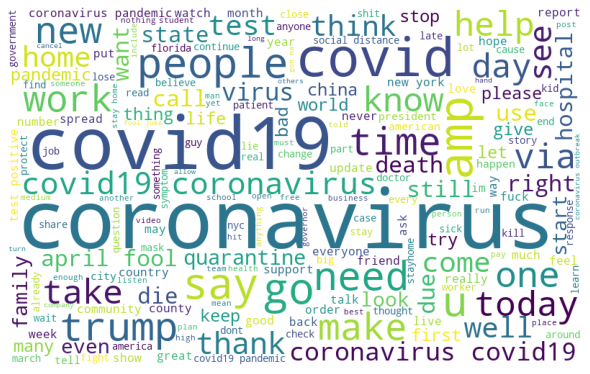

In [47]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
temp=' '.join(data_final['final'].tolist())
wordcloud = WordCloud(width = 800, height = 500, background_color ='white', min_font_size = 10).generate(temp)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()